In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.io import loadmat 

In [2]:
m = loadmat('/content/drive/MyDrive/Brain Computer Interface/data/subject_3/train_subject3_raw01.mat')

x = m['X']
y = m['Y']
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (121344, 32)
shape of y: (121344, 1)


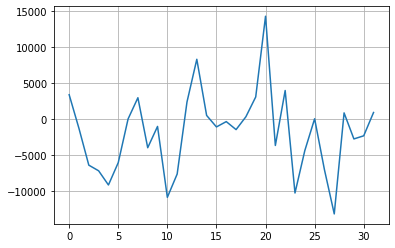

In [14]:
plt.plot(x[1])
plt.grid()
plt.show()

In [4]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(y)
print(onehot_encoded.shape)

(121344, 3)


In [5]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=24,random_state=0)
X_transformed = transformer.fit_transform(x)
X_transformed.shape

(121344, 24)

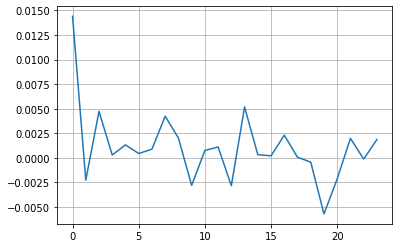

In [15]:
plt.plot(X_transformed[1])
plt.grid()
plt.show()

In [7]:
from skimage.restoration import denoise_wavelet

x_denoise = denoise_wavelet(X_transformed, method='BayesShrink', mode='soft', wavelet_levels=3, wavelet='sym8', rescale_sigma='True')

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


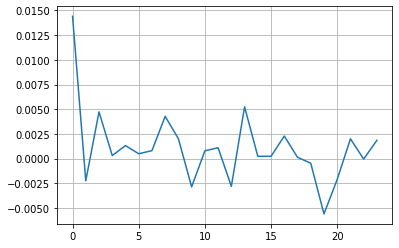

In [16]:
plt.plot(x_denoise[1])
plt.grid()
plt.show()

In [17]:
from scipy import signal
import numpy as np 

stft_feat = []
for i in range(len(x)):
  f, t, Zxx = signal.stft(x_denoise[i], fs= 512, nperseg=1000)
  stft_feat.append(np.abs(Zxx))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 1000 is greater than input length  = 24, using nperseg = 24
  .format(nperseg, input_length))


In [18]:
stft_feat = np.asarray(stft_feat)
stft_feat.shape

(121344, 13, 3)

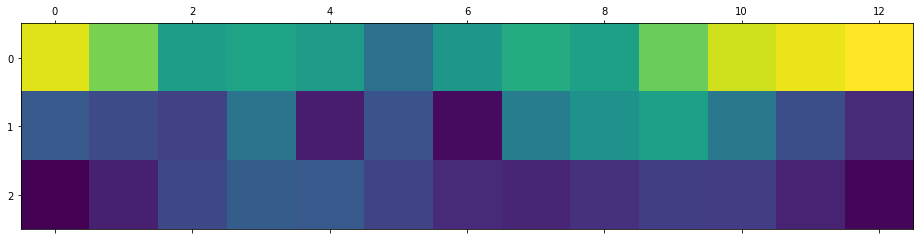

In [19]:
plt.matshow(stft_feat[1].T)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(stft_feat, onehot_encoded, train_size=0.7, random_state=7)

In [22]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, TimeDistributed,Flatten,LSTM 
from keras.models import Model

In [23]:
model = keras.models.load_model('/content/drive/MyDrive/Brain Computer Interface/model/model.h5')

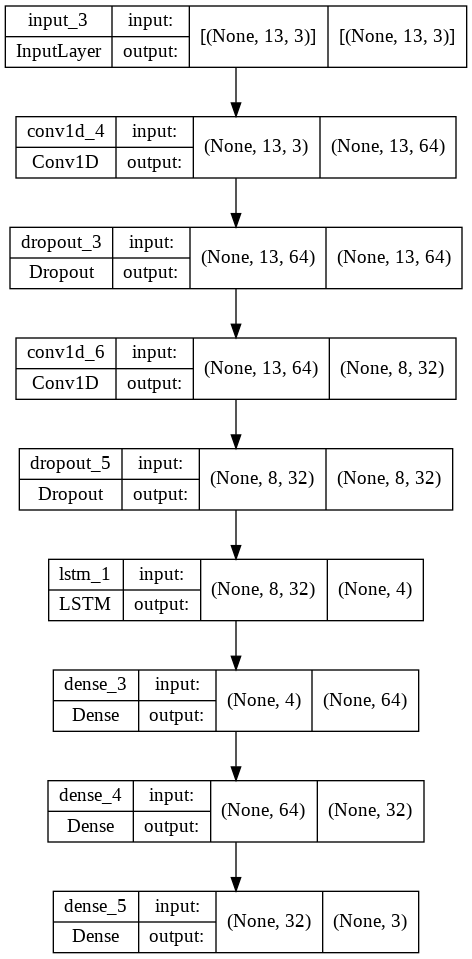

In [ ]:
import tensorflow as tf
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [24]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_split=0.3,epochs=300,batch_size=64,verbose=1)

Epoch 1/300
930/930 [==============================] - 17s 15ms/step - loss: 0.9943 - accuracy: 0.5291 - val_loss: 1.0010 - val_accuracy: 0.4336
Epoch 2/300
930/930 [==============================] - 15s 16ms/step - loss: 0.9017 - accuracy: 0.5694 - val_loss: 0.8484 - val_accuracy: 0.6026
Epoch 3/300
930/930 [==============================] - 13s 14ms/step - loss: 0.8644 - accuracy: 0.5917 - val_loss: 0.8374 - val_accuracy: 0.5627
Epoch 4/300
930/930 [==============================] - 13s 14ms/step - loss: 0.8407 - accuracy: 0.6083 - val_loss: 0.8614 - val_accuracy: 0.5927
Epoch 5/300
930/930 [==============================] - 14s 15ms/step - loss: 0.8205 - accuracy: 0.6206 - val_loss: 0.8947 - val_accuracy: 0.5605
Epoch 6/300
930/930 [==============================] - 13s 14ms/step - loss: 0.8003 - accuracy: 0.6314 - val_loss: 0.8433 - val_accuracy: 0.5874
Epoch 7/300
930/930 [==============================] - 13s 14ms/step - loss: 0.7771 - accuracy: 0.6460 - val_loss: 0.7728 - val_ac

In [25]:
# evaluate model
import time
start_time = time.time()
y_pred = model.predict(X_test, batch_size=64)
elapsed_time = time.time() - start_time
print(f"Elapsed time for prediction: {elapsed_time:.3f} seconds")
score = model.evaluate(X_test, y_test)
score

Elapsed time for prediction: 3.053 seconds
1138/1138 [==============================] - 4s 3ms/step - loss: 0.0864 - accuracy: 0.9734


[0.0864231288433075, 0.9734370112419128]

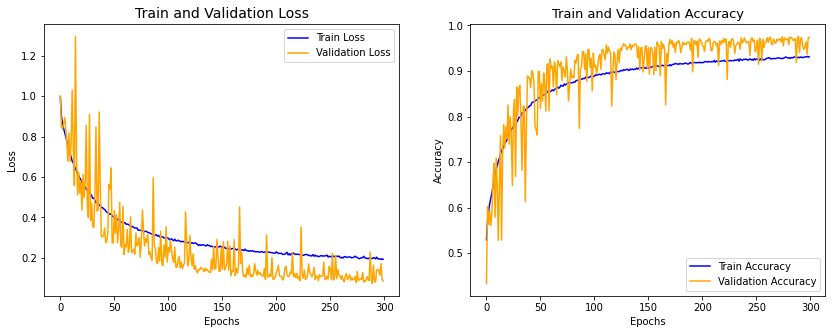

In [26]:
epochs = [i for i in range(300)]
loss_train = history.history['loss']
acc_train = history.history['accuracy']
loss_test = history.history['val_loss']
acc_test = history.history['val_accuracy']


fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(epochs, loss_train, color='blue', label='Train Loss')
ax[0].plot(epochs, loss_test, color='orange', label='Validation Loss')
ax[0].set_title('Train and Validation Loss', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()



ax[1].plot(epochs, acc_train, color='blue', label='Train Accuracy')
ax[1].plot(epochs, acc_test, color='orange',  label='Validation Accuracy')
ax[1].set_title('Train and Validation Accuracy', fontsize=13)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [27]:
import time 
s1 = time.time()
y_pred = model.predict(X_test)
s2 = time.time()
s = s2 -s1 
print(s)

5.1585540771484375


In [28]:
import numpy as np
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]

In [29]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test_non_category, y_predict_non_category)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_non_category, y_predict_non_category)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Macro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_non_category,y_predict_non_category, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_non_category, y_predict_non_category, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_non_category, y_predict_non_category, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[12220    71    94]
 [  173 11639   212]
 [  242   175 11578]]

Accuracy: 0.97

Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-score: 0.97

Macro Precision: 0.97
Macro Recall: 0.97
Macro F1-score: 0.97

Weighted Precision: 0.97
Weighted Recall: 0.97
Weighted F1-score: 0.97

Classification Report

              precision    recall  f1-score   support

     Class 1       0.97      0.99      0.98     12385
     Class 2       0.98      0.97      0.97     12024
     Class 3       0.97      0.97      0.97     11995

    accuracy                           0.97     36404
   macro avg       0.97      0.97      0.97     36404
weighted avg       0.97      0.97      0.97     36404



Text(0.5, 257.44, 'Predicted label')

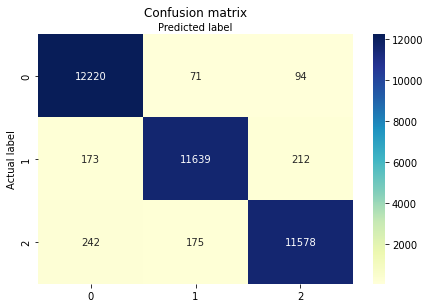

In [30]:
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_non_category, y_predict_non_category)
cnf_matrix
%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [31]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

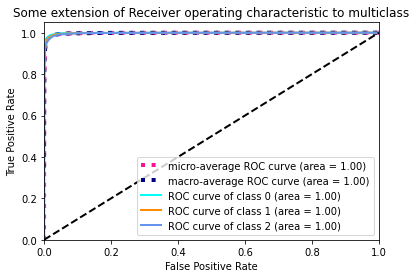

In [33]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()